# Info about PyNN 

![](https://neuralensemble.org/static/photos/pynn_logo.png)

- A Python package for simulator-independent specification of neuronal network models

- PyNN works with multiple simulators (SpiNNaker, NEST, Brain, Neuron, etc)

- If you want to install install PyNN on your local machine, see info http://neuralensemble.org/docs/PyNN/installation.html

- Paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2634533/

- PyNN website http://neuralensemble.org/docs/PyNN/index.html

- PyNN mailing list https://groups.google.com/g/neuralensemble



# Goal of this tutorial on PyNN

- Learn code elements to run a Spiking Neural Networks (SNNs) by using PyNN on the SpiNNaker neuromorphic system.


## knowledge assumptions: 

- basis of spiking neural network theory (https://neuronaldynamics.epfl.ch/online/index.html)
- familiarity with physical quatities related to electric circuits (e.g., voltages, conductances, currents, capacitances, etc)
- basic python coding (numpy, work with dictionaries, some matplotlib tools, etc)

# Content:

## network building and running 
1. neurons
    - cell types
    - populations
    - recording variables
    
2. connections
    - synapse types
    - connections types
    - projections

3. simulation managing
    - computational settings
    - save and load outputs
    - visualization tools

## expected take-home-points:

0. import the simulator
1. setup the simulator
2. decide the cell types 
3. design the populations
4. define the synapse types
5. select the connection algorithm
6. make the projections 
7. idealize the stimulus
8. run the simulation
9. save the results
10. recover the results
11. postprocessing (visualization or statistics, etc)
12. close the simulations

# step0: import the simulator

In [3]:
import pyNN.brian2 as sim 
from pyNN import space 

import numpy as np
import matplotlib.pyplot as plt

# note that if you use nest, import pyNN.nest as sim (see http://neuralensemble.org/docs/PyNN/backends.html)

# step1: setup the simulator

In [4]:
sim.setup(
    timestep=1, # [ms]
    min_delay=1, # [ms]
    max_delay=1*100) # [ms] # 

0

# step2: the cell types 

- cell models and source models
- point neuron (mono-compartment model)
- http://neuralensemble.org/docs/PyNN/standardmodels.html

## e.g., with sim.IF_cond_exp 

- Leaky integrate and fire model with fixed threshold and decaying-exponential post-synaptic conductance.
- as used in this bump model: https://arxiv.org/pdf/2003.13365.pdf

In [15]:
# parameter names

sim.IF_cond_exp.get_parameter_names()

['v_rest',
 'cm',
 'tau_m',
 'tau_refrac',
 'tau_syn_E',
 'tau_syn_I',
 'e_rev_E',
 'e_rev_I',
 'v_thresh',
 'v_reset',
 'i_offset']

In [17]:
# default parameters

standard_pars = sim.IF_cond_exp.default_parameters
standard_pars

# see parameters of the models http://neuralensemble.org/docs/PyNN/standardmodels.html

{'v_rest': -65.0,
 'cm': 1.0,
 'tau_m': 20.0,
 'tau_refrac': 0.1,
 'tau_syn_E': 5.0,
 'tau_syn_I': 5.0,
 'e_rev_E': 0.0,
 'e_rev_I': -70.0,
 'v_thresh': -50.0,
 'v_reset': -65.0,
 'i_offset': 0.0}

In [18]:
# define your own pars, 

testing_pars = {'tau_m': 20, 
                'cm': 1.0, 
                'v_rest': -60.0, 
                'v_reset': -60.0, 
                'v_thresh': -50.0, 
                'tau_syn_E': 5.0, 
                'tau_syn_I': 10.0, 
                'tau_refrac': 5, 
                'i_offset': 0.0, 
                'e_rev_E': 0.0, 
                'e_rev_I': -80.0}

In [19]:
# initial values

sim.IF_cond_exp().default_initial_values

{'v': -65.0, 'gsyn_exc': 0.0, 'gsyn_inh': 0.0}

# step3: making cell populations


In [20]:
# define dictionaries and settings

pops = {} # populations of exc and inh cells
n_cells = {} # specific number of exc or inh cells in pops
neuron_Model = {} # model of neuron adopted for the simulation
neuron_ModelPars = {} # model parameters 
initial_Values = {} # initial values of state variables (membrane potential and conductances)

In [21]:
# define the popolation of excitatory neurons 

popName = 'exc'

n_cells[popName] = 800
neuron_Model[popName] = sim.IF_cond_exp
neuron_ModelPars[popName] = testing_pars # or standard_pars or testing_pars
initial_Values[popName] = sim.IF_cond_exp.default_initial_values

pops[popName] = sim.Population(n_cells[popName], 
                               neuron_Model[popName],
                               neuron_ModelPars[popName],
                               structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0), 
                               initial_values={}, # e.g, initial_values={'v': sim.RandomDistribution('uniform', (-70.0, -60.0))},
                               label = popName)

pops[popName].record(['spikes','v','gsyn_exc','gsyn_inh'])   

print('the total number of excitatory cells is: ', pops['exc'].size)

the total number of excitatory cells is:  800


In [22]:
# define a popolation of inhibitory neurons in 1D

popName = 'inh'

n_cells[popName] = 200  # number of inhibitory cells
neuron_Model[popName] = sim.IF_cond_exp
neuron_ModelPars[popName] = testing_pars # or standard_pars or testing_pars
initial_Values[popName] = sim.IF_cond_exp.default_initial_values

pops[popName] = sim.Population(n_cells[popName], 
                               neuron_Model[popName],
                               neuron_ModelPars[popName],
                               structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0), 
                               initial_values={}, # e.g, initial_values={'v': sim.RandomDistribution('uniform', (-70.0, -60.0))},
                               label = popName)

pops[popName].record(['spikes','v','gsyn_exc','gsyn_inh']) 

print('the total number of inhibitory cells is: ', pops['inh'].size)

the total number of inhibitory cells is:  200


In [12]:
# the population dictionary

pops

{'exc': Population(800, IF_cond_exp(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='exc'),
 'inh': Population(200, IF_cond_exp(<parameters>), structure=Line(dx=1.0, x0=0.0, y=0.0, z=0.0), label='inh')}

In [23]:
# eventually defined random subsets of cells from the the population 

do_run = False
if do_run:
    pops['subsetA'] = pops['exc'].sample(75) 
    pops['subsetB'] = pops['inh'].sample(25) 

    pops['subsetA'].record(['spikes','v','gsyn_exc','gsyn_inh'])
    pops['subsetB'].record(['spikes','v','gsyn_exc','gsyn_inh'])

In [24]:
# get initial values

#pops['exc'].get_initial_values()
pops['exc'].initial_values

{'v': <larray: base_value=-65.0 shape=(800,) dtype=<class 'float'>, operations=[]>,
 'gsyn_exc': <larray: base_value=0.0 shape=(800,) dtype=<class 'float'>, operations=[]>,
 'gsyn_inh': <larray: base_value=0.0 shape=(800,) dtype=<class 'float'>, operations=[]>}

In [25]:
import seaborn as sns
import pandas as pd
pops['exc'].initial_values['v'][0:100]

array([-65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
       -65.])

In [26]:
pops['exc'].initial_values['gsyn_exc'][0:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
pops['exc'].initial_values['gsyn_inh'][0:100] # inhibitory conductance

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

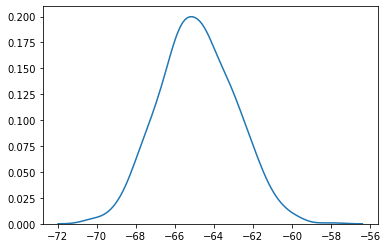

In [28]:
# change initial values, e.g., voltage
pops['exc'].initialize(v = sim.RandomDistribution('normal', (-65.0, 2.0)))
sns.kdeplot(pops['exc'].initial_values['v'][:]) # voltage

In [30]:
# some info to define network with 1D or 2D or 3D structures 
# remember cells are point model on a discretized line, surface or volume

"""
pops[popName] = sim.Population(n_cells[popName], 
                               neuron_Model[popName],
                               neuron_ModelPars[popName],
                               structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0), 
                               initial_values=None, # e.g, initial_values={'v': sim.RandomDistribution('uniform', (-70.0, -60.0))},
                               label = popName)
"""

structure = {}

structure['1D'] = space.Line(
                              dx=1.0, 
                              x0=0.0, 
                              y=0.0, 
                              z=0.0),

structure['2D'] = space.Grid2D(
                                aspect_ratio=1.0,
                                dx=1.0,
                                dy=1.0,
                                x0=0.0,
                                y0=0.0,
                                z=0,
                                fill_order='sequential', #'random'
                                rng=None,
                                )

structure['3D'] = space.Grid3D(
                                aspect_ratioXY=1.0,
                                aspect_ratioXZ=1.0,
                                dx=1.0,
                                dy=1.0,
                                dz=1.0,
                                x0=0.0,
                                y0=0.0,
                                z0=0.0,
                                fill_order='sequential', # 'random'
                                rng=None,
                                )

structure['Sphere'] = space.RandomStructure(
                                            boundary=space.Sphere(radius=5000), 
                                            origin=(0.0, 0.0, 0.0), 
                                            rng=None)


structure['Cuboid'] = space.RandomStructure(
                                            boundary=space.Cuboid(
                                                                width=10000, 
                                                                height=10000, 
                                                                depth=10000), 
                                                                origin=(0.0, 0.0, 0.0), 
                                                                rng=None)


# to explore the actual position of the cells:
print('the position of the 1st cell in a 3D structure is: ', list(structure['Cuboid'].generate_positions(n=1)))



the position of the 1st cell in a 3D structure is:  [array([4812.5355725]), array([-804.18664442]), array([493.87833289])]


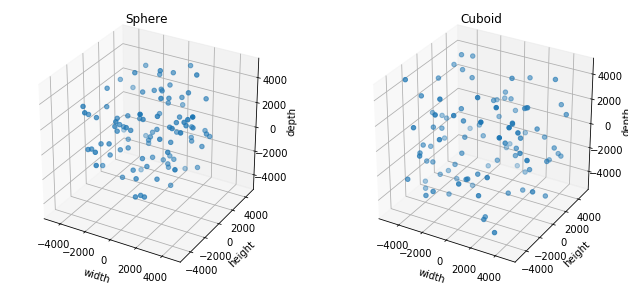

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121, projection='3d')
N=100
x=structure['Sphere'].generate_positions(n=N)[0]
y=structure['Sphere'].generate_positions(n=N)[1]
z=structure['Sphere'].generate_positions(n=N)[2]
im=ax.scatter(x, y, z)
im=ax.set_title('Sphere')
im=ax.set_xlabel('width')
im=ax.set_ylabel('height')
im=ax.set_zlabel('depth')
# check radius with 10,100,1000

ax = fig.add_subplot(122, projection='3d')
N=100
x=structure['Cuboid'].generate_positions(n=N)[0]
y=structure['Cuboid'].generate_positions(n=N)[1]
z=structure['Cuboid'].generate_positions(n=N)[2]
im=ax.scatter(x, y, z)
im=ax.set_title('Cuboid')
im=ax.set_xlabel('width')
im=ax.set_ylabel('height')
im=ax.set_zlabel('depth')
# check resizing width, height and depth (special cases of 1D and 2D and 3D)

#len(structure['Cuboid'].generate_positions(n=10)[0])
#structure['Cuboid'].generate_positions(n=10)
# The library has a representation of the [topology of the network](http://neuralensemble.org/docs/PyNN/reference/space.html) :

# step4: synapses types 

In [32]:
# static synapse weight and delay

weights = np.random.normal(loc=0.04, scale=0.01)
static_synapse = sim.StaticSynapse(weight=weights, delay=0.5) # weights in [uS] and delay in [ms]

# note1: if you use a model with current based synapses, the weights are in nA, 
# otherewise are uS for conductance based synapses models 

# step5: connectors types 


In [33]:
# all to all connections

connector = sim.AllToAllConnector(allow_self_connections=True) # autapses=True

In [34]:
# all to all connections with probability

prob = 0.25 # point prob
prob = np.random.normal(loc=0.5, scale=0.1) # distribution of prob
connector = sim.FixedProbabilityConnector(p_connect=prob)

In [35]:
# distance based probability connections

d_rule = "exp(-d)" # or d_expression = "d<5"
connector = sim.DistanceDependentProbabilityConnector(d_expression=d_rule)

In [36]:
# one to one connections

connector = sim.OneToOneConnector()

In [37]:
# fixed number of pre synptic neurons randomly taken link to all pre syn neurons

connector = sim.FixedNumberPreConnector(n = 50, allow_self_connections=True)

In [38]:
# fixed number of post synptic neurons randomly taken link to all post syn neurons

connector = sim.FixedNumberPostConnector(n = 50, allow_self_connections=True)

In [39]:
# small-world connections

do_run = False
if do_run:
    connector = sim.SmallWorldConnector(
                                    degree, # the region length where nodes will be connected locally
                                    rewiring, # the probability of rewiring each edge
                                    allow_self_connections=True,
                                    safe=True,
                                    verbose=False,
                                    n_connections=None, # if specified, the number of efferent synaptic connections per neuron
                                    )


In [40]:
# CSA Connection Set Algebra constructor ( Djurfeldt 2012 https://pubmed.ncbi.nlm.nih.gov/22437992/)

do_run = False
if do_run:
    #cset = a connection set object
    connector = CSAConnector(cset, safe=True, callback=None)


In [41]:
# from file to connector, i.e., [i, j, weight, delay]

do_run = False
if do_run:
    file = 'yourFile.txt'
    connector = sim.FromFileConnector(
                                    file,
                                    distributed=False,
                                    safe=True,
                                    callback=None,
                                    verbose=False,
                                )

In [42]:
# list based connections, i.e., [i, j, weight, delay]

# one-to-one like list
#            [i, j,  w,   d]
givenList = [[0, 0, 0.08, 1],
             [1, 1, 0.08, 1],
             [2, 2, 0.08, 1],
             [3, 3, 0.08, 1],
             [4, 4, 0.08, 1]]
             #...

connector = sim.FromListConnector(conn_list=givenList)

# powerful tool to draw your own connectivity

## Example of a function to compute a list for the FromListConnector

## e.g., list of Distance based Probability Connections with Distance based Delay (DPCDD)

In [43]:
def compute_DPCDD(n_cells_i, n_cells_j, weights, d_thresh, p_thresh, width): 
    
    v_c = 0.35 # mm/ms
    d0 = 1 # ms
    scale = 1
    
    connections = {}
    probabilities = {}
    distances = {}

    connections = []
    probabilities = []
    distances = []
    for pre in range(n_cells_i):
        for post in range(n_cells_j):
            d_ij = np.sqrt((pre - post)**2)
            delay = d0 + d_ij / v_c # i.e., v = s/t -> t = s/v
            if d_ij > d_thresh: 
                distances.append(d_ij)
                p_ij = scale*np.exp(-0.5 * (d_ij**2/width**2))
                probabilities.append(p_ij)

                if p_ij > p_thresh:
                    connections.append([pre, post, weights, delay])#, [d_ij, p_ij]])

    return connections, distances, probabilities

## operative example: center-surround connections 

In [44]:
# -> see https://link.springer.com/referenceworkentry/10.1007%2F978-1-4614-6675-8_569)
# -> see http://www.scholarpedia.org/article/Neural_inhibition

Text(0.5, 1, 'histogram of delays')

WARNING    /home/alberto-int/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


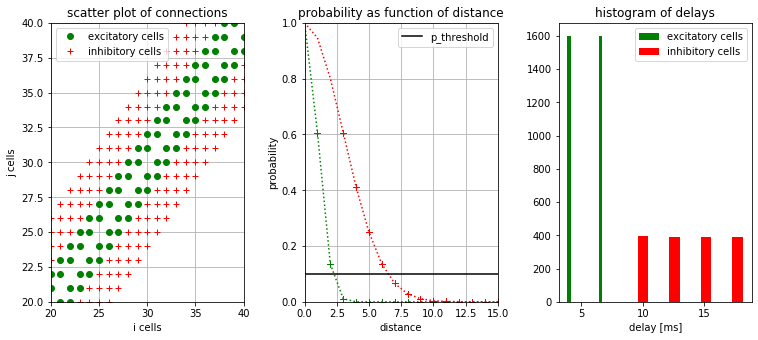

In [48]:
# define parameters

n_cell = {'excitatory': pops['exc'].size, 'inhibitory': pops['inh'].size}
weights = {'excitatory': 0.008, 'inhibitory': 0.008}
d_thresh = {'excitatory': 0, 'inhibitory': 2} 
p_thresh = {'excitatory': 0.1, 'inhibitory': 0.1}
width = {'excitatory': 1, 'inhibitory': 3}

connections = {}
distances = {}
probabilities = {}

for synapse_type in ['excitatory', 'inhibitory']:
    connections[synapse_type], distances[synapse_type], probabilities[synapse_type] = compute_DPCDD(
                                                                                                    n_cell[synapse_type], 
                                                                                                    n_cell[synapse_type], 
                                                                                                    weights[synapse_type], 
                                                                                                    d_thresh[synapse_type], 
                                                                                                    p_thresh[synapse_type],
                                                                                                    width[synapse_type])

###################################################################################################################### visual check
fig, ax = plt.subplots(1,3, figsize=(11,5))
fig.tight_layout(pad=3)
axes_list = fig.axes

axes_list[0].plot(np.asarray(connections['excitatory']).T[0], np.asarray(connections['excitatory']).T[1],'go', label='excitatory cells')
axes_list[0].plot(np.asarray(connections['inhibitory']).T[0], np.asarray(connections['inhibitory']).T[1],'r+', label='inhibitory cells')
axes_list[0].grid()
axes_list[0].legend()
axes_list[0].set_title('scatter plot of connections')
axes_list[0].set_xlabel('i cells')
axes_list[0].set_ylabel('j cells')
axes_list[0].set_xlim(20,40)
axes_list[0].set_ylim(20,40)

axes_list[1].plot(distances['excitatory'],probabilities['excitatory'],'g+')
axes_list[1].plot(distances['inhibitory'],probabilities['inhibitory'],'r+') 
axes_list[1].plot(np.arange(0, 50), 1*np.exp(-0.5 * (np.arange(0, 50)**2/width['excitatory']**2)), 'g:')
axes_list[1].plot(np.arange(0, 50), 1*np.exp(-0.5 * (np.arange(0, 50)**2/width['inhibitory']**2)), 'r:')
axes_list[1].grid()
axes_list[1].set_xlim(0,15)
axes_list[1].set_ylim(0,1)
axes_list[1].axhline(p_thresh['excitatory'], color='k', label='p_threshold', )
axes_list[1].set_title('probability as function of distance')
axes_list[1].set_xlabel('distance')
axes_list[1].set_ylabel('probability')
axes_list[1].legend()

p=axes_list[2].hist(np.asarray(connections['excitatory']).T[3], bins=10, color='green', label='excitatory cells')
p=axes_list[2].hist(np.asarray(connections['inhibitory']).T[3], bins=10, color='r', label='inhibitory cells')
axes_list[2].set_xlabel('delay [ms]')
axes_list[2].legend()
axes_list[2].set_title('histogram of delays')

# Plots show connections with 2 cells local excitation and 4 cells surrounding inhibition, no autapses

In [49]:
# e.g., i, j, weights, delays

connections['excitatory'][0:10]

[[0, 1, 0.008, 3.857142857142857],
 [0, 2, 0.008, 6.714285714285714],
 [1, 0, 0.008, 3.857142857142857],
 [1, 2, 0.008, 3.857142857142857],
 [1, 3, 0.008, 6.714285714285714],
 [2, 0, 0.008, 6.714285714285714],
 [2, 1, 0.008, 3.857142857142857],
 [2, 3, 0.008, 3.857142857142857],
 [2, 4, 0.008, 6.714285714285714],
 [3, 1, 0.008, 6.714285714285714]]

In [47]:
# e.g., i, j, weights, delays

connections['inhibitory'][0:10]

[[0, 3, 0.008, 9.571428571428571],
 [0, 4, 0.008, 12.428571428571429],
 [0, 5, 0.008, 15.285714285714286],
 [0, 6, 0.008, 18.142857142857142],
 [1, 4, 0.008, 9.571428571428571],
 [1, 5, 0.008, 12.428571428571429],
 [1, 6, 0.008, 15.285714285714286],
 [1, 7, 0.008, 18.142857142857142],
 [2, 5, 0.008, 9.571428571428571],
 [2, 6, 0.008, 12.428571428571429]]

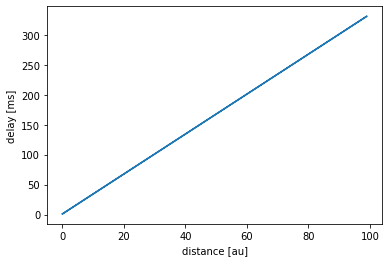

In [50]:
# check the linearity of the delay
do_run = True

if do_run:

    %matplotlib inline
    d0=1
    v_c=0.3

    d_ij=[]
    delay_ij=[]
    for pre in range(100):
        for post in range(100):
            d_ij_ = np.sqrt((pre - post)**2)
            delay_ = d0 + d_ij_ / v_c # v = s/t -> t = s/v
            d_ij += [d_ij_]
            delay_ij += [delay_]

    plt.plot(d_ij, delay_ij)
    plt.xlabel('distance [au]')
    plt.ylabel('delay [ms]')

# step6: designing projections

In [51]:
# making general connections 

from pyNN.random import NumpyRNG, RandomDistribution

pconn = 0.02
rngseed = 98766987
rng = NumpyRNG(seed=rngseed, parallel_safe=True)

exc_cells = pops['exc']
inh_cells = pops['inh']
w_exc = 0.04 # uS
w_inh = 0.51 # uS
delay = 2 # ms

exc_conn = sim.FixedProbabilityConnector(pconn, rng=rng)
inh_conn = sim.FixedProbabilityConnector(pconn, rng=rng)

connections = {
    
    'e2e': sim.Projection(
        exc_cells, 
        exc_cells, 
        exc_conn, 
        receptor_type='excitatory',
        synapse_type=sim.StaticSynapse(weight=w_exc, delay=delay)),
    
    'e2i': sim.Projection(
        exc_cells, 
        inh_cells,
        exc_conn,
        receptor_type='excitatory',
        synapse_type=sim.StaticSynapse(weight=w_exc, delay=delay)),
    
    'i2e': sim.Projection(
        inh_cells,
        exc_cells, 
        inh_conn, 
        receptor_type='inhibitory',
        synapse_type=sim.StaticSynapse(weight=w_inh, delay=delay)),
    
    'i2i': sim.Projection(
        inh_cells, 
        inh_cells, 
        inh_conn,
        receptor_type='inhibitory',
        synapse_type=sim.StaticSynapse(weight=w_inh, delay=delay))

        }

connections

{'e2e': Projection("exc→exc"),
 'e2i': Projection("exc→inh"),
 'i2e': Projection("inh→exc"),
 'i2i': Projection("inh→inh")}

In [52]:
# note for the the space arg with 2 or 3 dimensions

"""
pops[popName] = sim.Population(n_cells[popName], 
                               neuron_Model[popName],
                               neuron_ModelPars[popName],
                               structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0), 
                               initial_values=None, # e.g, initial_values={'v': sim.RandomDistribution('uniform', (-70.0, -60.0))},
                               label = popName)

"""


s = {}
s['1D'] = space.Space(axes = 'x')
s['2D'] = space.Space(axes = 'xy')
s['3D'] = space.Space(axes = 'xyz')
s['Sphere'] = space.Space(axes = 'xyz')
s['Cuboid'] = space.Space(axes = 'xyz')


# step7: setting the thalamic stimulus

(0, 1000)

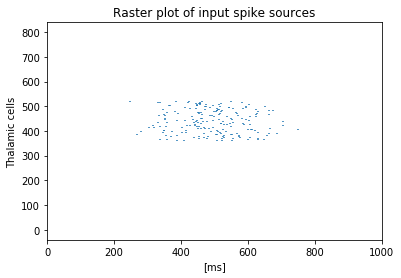

In [54]:
# manual function 
#
# define the list of spike sources, e.g, with a gaussian input 

n_cells['thalamus' ] = n_cells['exc']
spike_times = [[]]*n_cells['thalamus' ] #list of spike lists, where one spike list is related to one spike source

# randomly select the id source
random_sources_idx = [np.random.randint(n_cells['thalamus' ]*0.45, n_cells['thalamus' ]*0.65) for i in range(n_cells['thalamus' ])]

# randomly assign for each id source a sequence of spike times, i.e., when the cell spikes
for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([np.random.normal(loc=500, scale=100) for n in range(5)])

#spike_times
%matplotlib inline
a = plt.eventplot(spike_times)
plt.xlabel('[ms]')
plt.ylabel('Thalamic cells')
plt.title('Raster plot of input spike sources')
plt.xlim(0, 1000)

#spike_times[400:600]
# add plot spikes/sec

In [55]:
# define the spike sources populations and projections

do_run = False

if do_run:
    neuron_Model['thalamus' ] = sim.SpikeSourceArray(spike_times=spike_times)

    pops['thalamus' ] = sim.Population(n_cells['thalamus' ], 
                                   neuron_Model['thalamus' ],
                                   label = 'Thalamus' )
                                  # add spatial constraint


    connections['t2e'] = sim.Projection(pops['thalamus'], pops['exc'],
                                               connector = sim.OneToOneConnector(),
                                               synapse_type = sim.StaticSynapse(weight=0.08, delay=1),
                                               receptor_type = 'excitatory',
                                                #space=<pyNN.space.Space object at 0x7ff8f25a2110>,
                                               label = 'thalamus-exc connections'
                                                )
    
    connections['t2i'] = sim.Projection(pops['thalamus'], pops['inh'],
                                           connector = sim.OneToOneConnector(),
                                           synapse_type = sim.StaticSynapse(weight=0.08, delay=1),
                                           receptor_type = 'excitatory',
                                            #space=<pyNN.space.Space object at 0x7ff8f25a2110>,
                                           label = 'thalamus-inh connections'
                                            )


In [56]:
# otherwise define a spike sources from poisson process

do_run = False

if do_run:
    stim_dur = 50.    # (ms) duration of random stimulation
    rate = 100.       # (Hz) frequency of the random stimulation
    
    ext_stim = sim.Population(
        20, sim.SpikeSourcePoisson(rate=rate, duration=stim_dur),
        label="expoisson")
    
    rconn = 0.01
    ext_conn = sim.FixedProbabilityConnector(rconn)
    ext_stim.record("spikes")

    connections['ext2e'] = sim.Projection(
        ext_stim, 
        exc_cells, 
        ext_conn,
        receptor_type='excitatory',
        synapse_type=sim.StaticSynapse(weight=0.1))
    
    connections['ext2i'] = sim.Projection(
        ext_stim, 
        inh_cells,
        ext_conn,
        receptor_type='excitatory',
        synapse_type=sim.StaticSynapse(weight=0.1))
    
#connections

# step8: run simulation

In [57]:
do_run = False
if do_run:
    simtime = 1000
    sim.run(simtime) # time_bins=200 [ms]

# wait some minuts and it prints several info about HW and SW...

# step9: save results in a folder

In [61]:
do_run=False
if do_run:   
    outputs = {}
    for layer in ['exc', 'inh']:

        # save on the notebook space
        outputs[layer] = pops[layer].get_data()

        # save in the folder space
        for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
            pops[layer].write_data(str(layer) + '_' + str(recording) + '.pkl')


# step10: recover results

In [62]:
def recover_results(outputs):
    results = {}
    for key in outputs.keys(): # to extract the name of the layer, e.g., Exc, Inh, Thalamus, etc  
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(key, analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results

# check results
#results = recover_results(outputs)
#results.keys()

# step11: postprocessing (looking the results)

In [63]:
# eventually import pkl files or use matplolib tools (see examples to plot voltage, spikes, conductances, etc)

do_run = False
if do_run:
    import pickle
    
    # e.g., 
    with open('Exc_v.pkl', 'rb') as f:
            data = pickle.load(f)


# step12: close simulation


In [64]:
do_run = False
if do_run:
    sim.end()